# VCGC: Vertex Coloring with Grover's Circuit 
Rudimentary Curcuit To Run Grover's Search Algorithm for a vertex coloring instance on the AER simulator and IBM's Quantum Computer. 

1. Prepare the circuit and add the uniform state preparation operator.

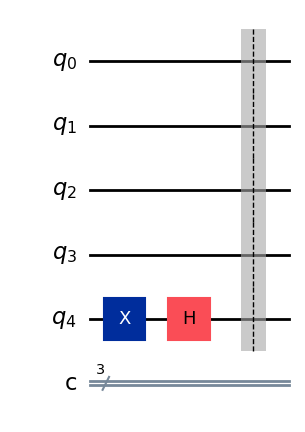

In [102]:
from qiskit import *
import matplotlib.pyplot as plt
import numpy as np  

# Create a Quantum Circuit acting on a quantum register of 5 qubits
qc = QuantumCircuit(5,3)

# Subcircuit for uniform state preparation operator
spo = QuantumCircuit(3,name="state_prep")

# Add a H gate on all qubits except the last one
# This will give the superposition of all the qubits except the last one
for qubit in range(3):
    spo.h(qubit)
qc.x(4)
qc.h(4)
qc.barrier()

qc.decompose(gates_to_decompose="state_prep").draw('mpl')

2. Manually creating the oracle circuit for evaulating the scaled down vertex coloring problem shown below

![Simple Vertex Coloring problem](vertex_coloring_instance.png)

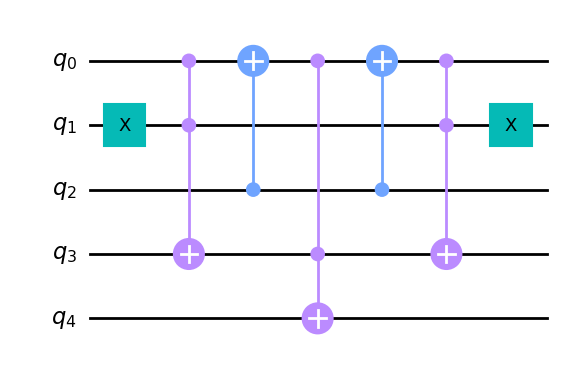

In [103]:

# Create a quantum subcircuit for grover oracle
grover_oracle = QuantumCircuit(5, name="grover_oracle")
grover_oracle.x(1)
grover_oracle.ccx(0,1,3)
grover_oracle.cx(2,0)
grover_oracle.ccx(0,3,4)
grover_oracle.cx(2,0)
grover_oracle.ccx(0,1,3)
grover_oracle.x(1)

grover_oracle.draw('mpl',style='clifford')


3. Defining the diffusion operator

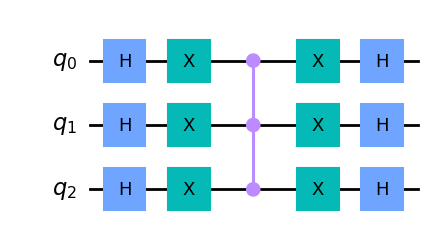

In [104]:
# Create a quantum subcircuit for grover diffusion operator
grover_diffusion = QuantumCircuit(3, name="grover_diffusion")
grover_diffusion.h([0,1,2])
grover_diffusion.x([0,1,2])
grover_diffusion.ccz(0,1,2)
grover_diffusion.x([0,1,2])
grover_diffusion.h([0,1,2])

grover_diffusion.draw('mpl',style='clifford')

4. Connect the whole circuit together together for the first iteration

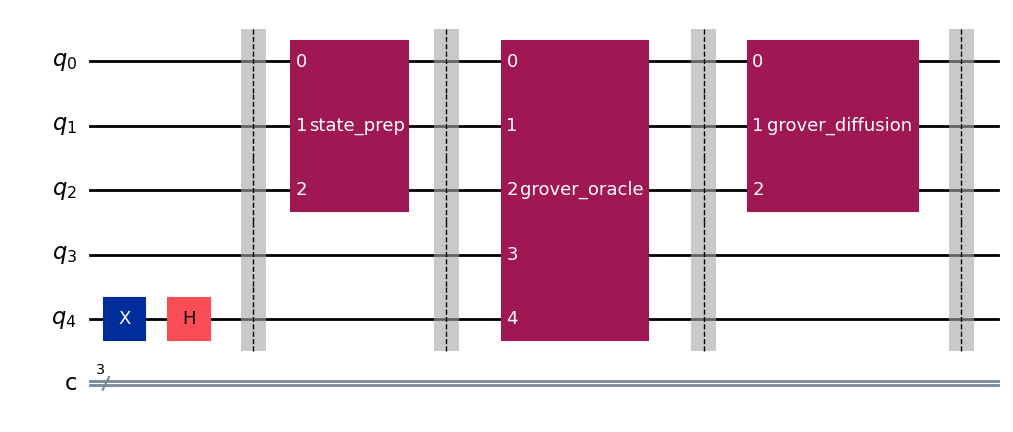

In [105]:
# Combining the subcircuits to form the complete Grover's algorithm
qc.append(spo, [0, 1, 2])
qc.barrier()
qc.append(grover_oracle, [0,1,2,3,4])
qc.barrier()
qc.append(grover_diffusion, [0,1,2])
qc.barrier()

qc.draw('mpl')

5. Add measurements and running the circuit of the AER simulator

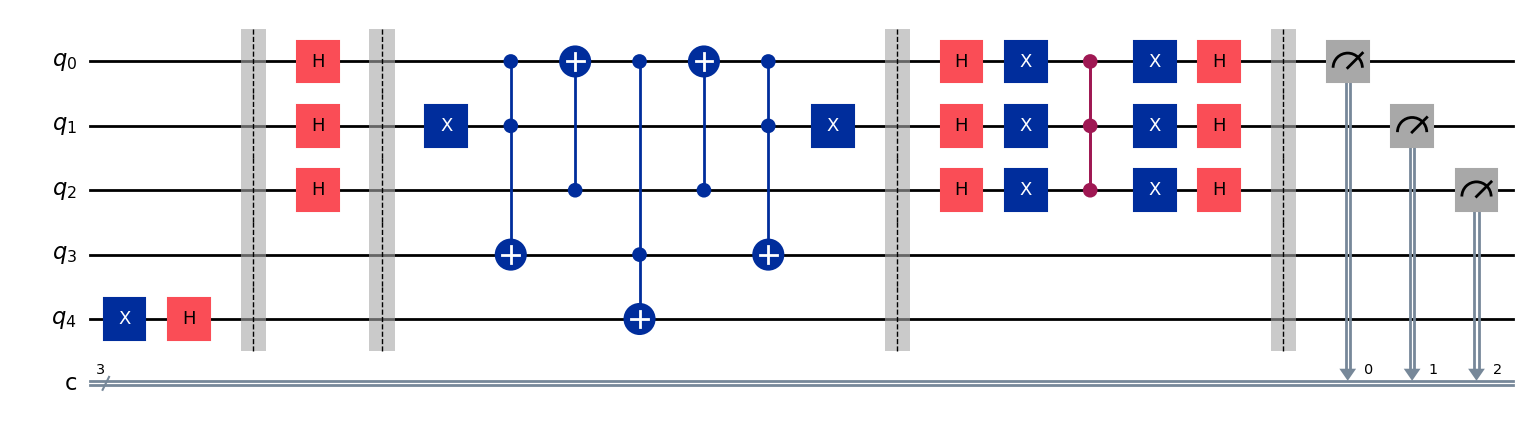

In [106]:

# Measure the first 3 qubits
qc.measure([0, 1, 2], [0, 1, 2])
qc_decomposed : QuantumCircuit = qc.decompose(gates_to_decompose=["state_prep", "grover_oracle", "grover_diffusion"])
qc_decomposed.draw('mpl')


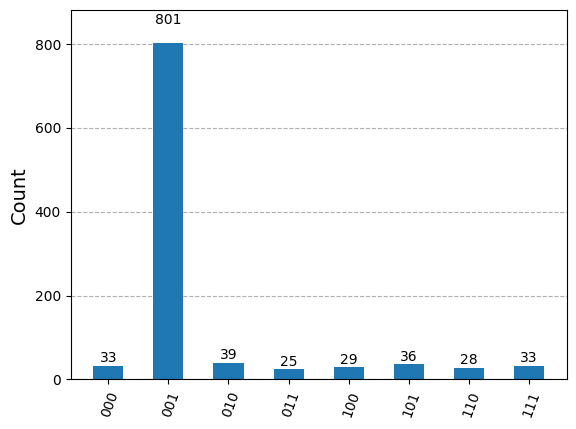

In [107]:
from qiskit_aer import Aer
# import basic plot tools
from qiskit.visualization import plot_histogram

# Creating the backend
qasm_sim = Aer.get_backend('qasm_simulator')
result = qasm_sim.run(qc_decomposed).result()
counts = result.get_counts()
plot_histogram(counts)


6. Running on a real device

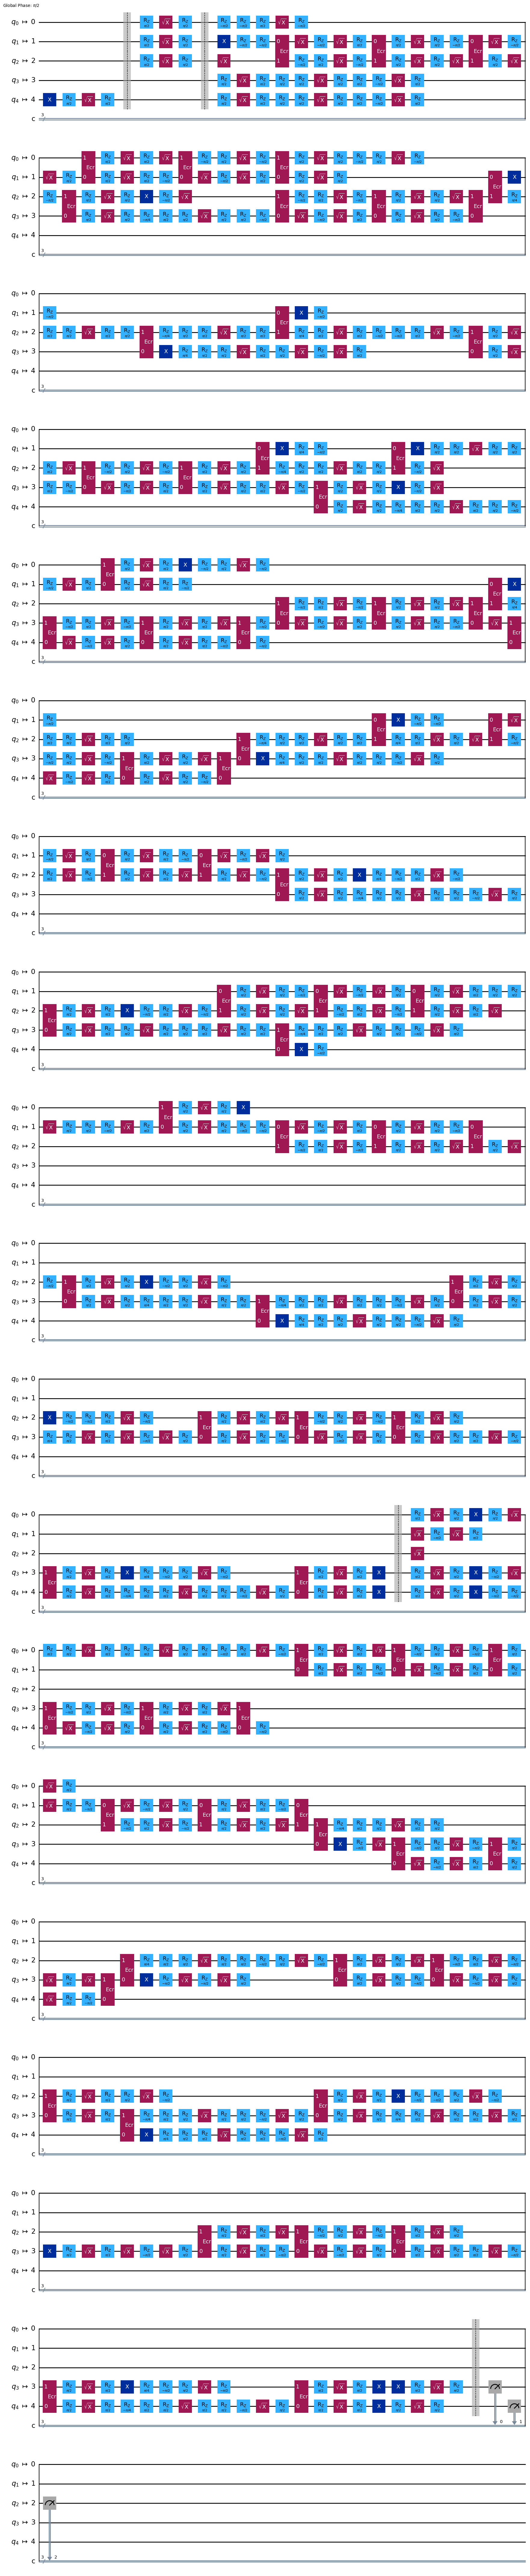

In [129]:

# Run our circuit on the least busy backend. Transpiling before running.
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True)

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=0)

circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")


In [132]:
print(circuit_isa.depth())

445


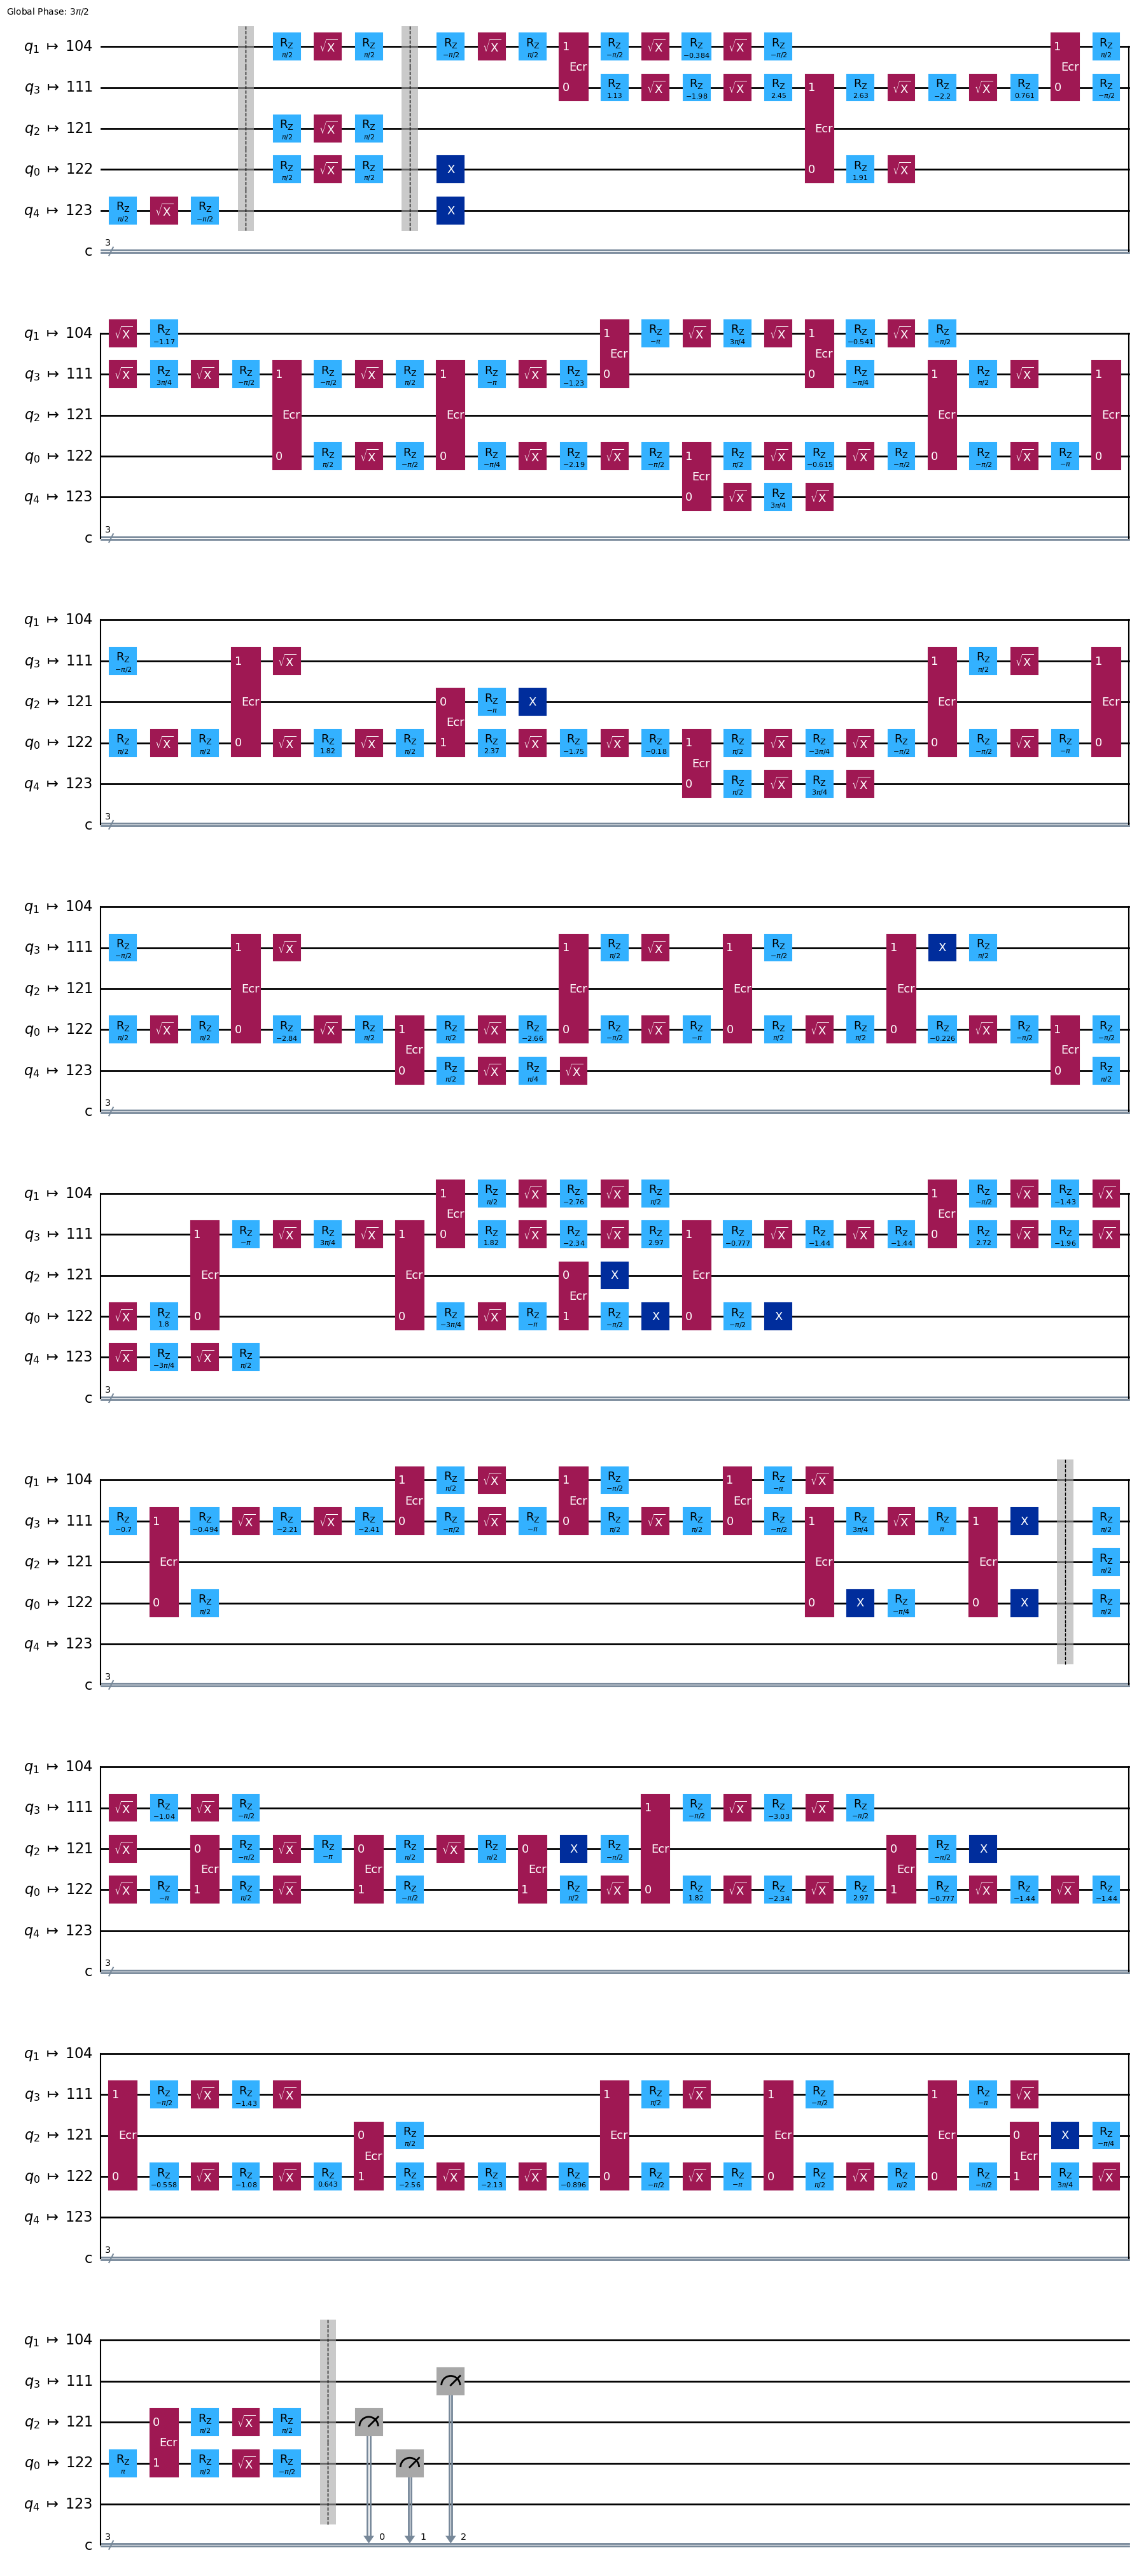

In [133]:
optimized_pm = generate_preset_pass_manager(target=target, optimization_level=3)

optimized_circuit_isa = optimized_pm.run(qc)
optimized_circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [134]:
print(optimized_circuit_isa.depth())

203


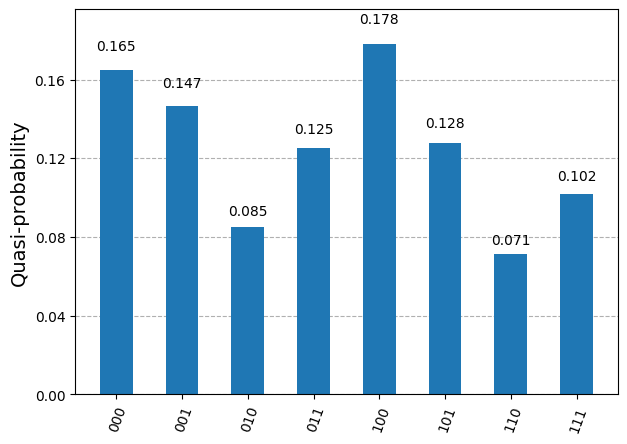

In [130]:
# With optimization level 0
from qiskit_ibm_runtime import Sampler
from qiskit.visualization import plot_distribution
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.c.get_counts()
plot_distribution(dist)

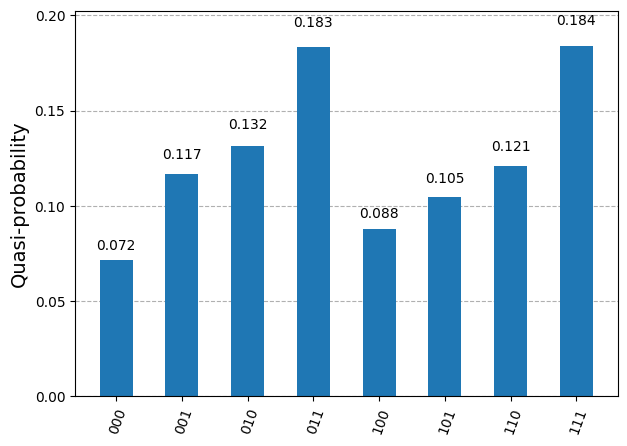

In [128]:
# With optimization level 3
from qiskit_ibm_runtime import Sampler
from qiskit.visualization import plot_distribution
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()
# job = service.job('cydv20r01rbg008k3kc0')
# job_result = job.result()
dist = result[0].data.c.get_counts()
# print(dist)
plot_distribution(dist)
